In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.model_zoo import load_url

from torchvision import transforms
import numpy as np
import cv2 as cv

from PIL import Image
import PIL

import argparse
import os

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class _ChannelShrink(nn.Module):
    """Channel attention module"""

    def __init__(self, in_planes, out_planes=256, reduction=8):
        super(_ChannelShrink, self).__init__()
        self.specificdim = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 1, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.specificdim(x)


class _ChannelAttention(nn.Module):
    """Channel attention module"""

    def __init__(self, in_planes, out_planes=256, reduction=8):
        super(_ChannelAttention, self).__init__()
        self.specificdim = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 1, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(inplace=True)
        )
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_planes, out_planes // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(out_planes // reduction, out_planes, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.specificdim(x)
        out = self.attention(x) * x
        return out


class _AggregationBlock(nn.Module):
    """Local receptive field enhancement"""

    def __init__(self, in_planes, dilated):
        super(_AggregationBlock, self).__init__()
        self.downdim = nn.Conv2d(
            in_planes, in_planes // 4, 1, bias=False)

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_planes // 4, in_planes // 4,
                      (3, 1), padding=(1 * dilated[0], 0), bias=False, dilation=(dilated[0], 1)),
            nn.ReLU(),
            nn.Conv2d(in_planes // 4, in_planes // 4,
                      (1, 3), stride=1, padding=(0, 1 * dilated[0]), bias=False, dilation=(1, dilated[0])),
            nn.BatchNorm2d(in_planes // 4),
            nn.ReLU(),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_planes // 4, in_planes // 4,
                      (3, 1), padding=(1 * dilated[1], 0), bias=False, dilation=(dilated[1], 1)),
            nn.ReLU(),
            nn.Conv2d(in_planes // 4, in_planes // 4,
                      (1, 3), stride=1, padding=(0, 1 * dilated[1]), bias=False, dilation=(1, dilated[1])),
            nn.BatchNorm2d(in_planes // 4),
            nn.ReLU(),
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_planes // 4, in_planes // 4,
                      (3, 1), padding=(1 * dilated[2], 0), bias=False, dilation=(dilated[2], 1)),
            nn.ReLU(),
            nn.Conv2d(in_planes // 4, in_planes // 4,
                      (1, 3), stride=1, padding=(0, 1 * dilated[2]), bias=False, dilation=(1, dilated[2])),
            nn.BatchNorm2d(in_planes // 4),
            nn.ReLU(),
        )

    def forward(self, x):
        x_ = self.downdim(x)
        branch1 = self.branch1(x_)
        branch2 = self.branch2(x_)
        branch3 = self.branch3(x_)
        merge = torch.cat([branch1, branch2, branch3, x_], dim=1)
        return merge


class _AggregationReplace(nn.Module):
    """Local receptive field enhancement"""

    def __init__(self, in_planes):
        super(_AggregationReplace, self).__init__()
        self.smooth = nn.Sequential(
            nn.Conv2d(in_planes, in_planes, 1, bias=False),
            nn.BatchNorm2d(in_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.smooth(x)
        return x


class _BoundaryAwareness(nn.Module):
    """Edge awareness module"""

    def __init__(self, in_fea=[64, 128], mid_fea=128, out_fea=2):
        super(_BoundaryAwareness, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_fea[0], in_fea[0], kernel_size=3, stride=1, padding=1, groups=in_fea[0], bias=False),
            nn.BatchNorm2d(in_fea[0]),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_fea[0], mid_fea, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_fea)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_fea[1], in_fea[1], kernel_size=3, stride=1, padding=1, groups=in_fea[1], bias=False),
            nn.BatchNorm2d(in_fea[1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_fea[1], mid_fea, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_fea)
        )
        self.conv3 = nn.Conv2d(
            mid_fea * 2, out_fea, kernel_size=3, padding=1, bias=True)
        # self.conv4 = nn.Conv2d(
        #     mid_fea * 2, out_fea, kernel_size=1, padding=0, bias=True)

    def forward(self, x1, x2):
        _, _, h, w = x1.size()

        edge1_fea = self.conv1(x1)  # (128)
        # edge1 = self.conv3(edge1_fea)
        edge2_fea = self.conv2(x2)  # (64)
        # edge2 = self.conv3(edge2_fea)

        edge1_fea = F.interpolate(edge1_fea, size=(
            h, w), mode='bilinear', align_corners=True)
        edge2_fea = F.interpolate(edge2_fea, size=(
            h, w), mode='bilinear', align_corners=True)
        # edge2 = F.interpolate(edge2, size=(
        #     h, w), mode='bilinear', align_corners=True)

        # edge = torch.cat([edge1, edge2], dim=1)
        edge_fea = torch.cat([edge1_fea, edge2_fea], dim=1)
        edge = self.conv3(edge_fea)

        return edge, edge_fea


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # bottom-up
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Channel Attention
        self.c2_a = _ChannelAttention(in_planes=64)
        self.c3_a = _ChannelAttention(in_planes=128)
        self.c4_a = _ChannelAttention(in_planes=256)
        self.c5_a = _ChannelAttention(in_planes=512)

        # self.smooth3 = _AggregationBlock(256, dilated=[1, 2, 4])
        # self.smooth2 = _AggregationBlock(256, dilated=[3, 6, 9])
        # self.smooth1 = _AggregationBlock(256, dilated=[7, 9, 13])
        self.smooth3 = _AggregationReplace(256)
        self.smooth2 = _AggregationReplace(256)
        self.smooth1 = _AggregationReplace(256)

        # Binary Branch
        self.edge = _BoundaryAwareness(in_fea=[64, 128])

        # Classifier
        self.classifier1 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.classifier2 = nn.Conv2d(512, num_classes, kernel_size=1)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _upsample_add(self, x, y):
        _, _, H, W = y.size()
        return F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True) + y

    def forward(self, x):
        _, _, h, w = x.size()

        x = self.relu1(self.bn1(self.conv1(x)))
        # x = self.relu2(self.bn2(self.conv2(x)))
        # x = self.relu3(self.bn3(self.conv3(x)))
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)  # (-1, 64, 128, 128)
        c3 = self.layer2(c2)  # (-1, 128, 64, 64)
        c4 = self.layer3(c3)  # (-1, 256, 32, 32)
        c5 = self.layer4(c4)  # (-1, 512, 16, 16)

        '''c2_a = self.c2_a(c2)  # (-1, 128, 128, 128)
        c3_a = self.c3_a(c3)  # (-1, 128,  64,  64)
        c4_a = self.c4_a(c4)  # (-1, 128,  32,  32)'''

        # Stage Contextual Attention Mechanism (SCAM) Module
        p5 = self.c5_a(c5)
        p4 = self._upsample_add(p5, self.c4_a(c4))
        p3 = self._upsample_add(p4, self.c3_a(c3))
        p2 = self._upsample_add(p3, self.c2_a(c2))

        # Multi scale aggregation
        # c3_b = self._upsample_add(self.smooth3(c4_a), self.smooth2(c3_a))
        # c2_b = self._upsample_add(c3_b, self.smooth1(c2_a))

        # [Semantic Gap Compensation Block (SGCB) Module] Reason for not using P5: The global receptive field
        # may learn the noise information, which will affect the accuracy improvement.
        p4 = self.smooth3(p4)
        p3 = self._upsample_add(p4, self.smooth2(p3))
        p2 = self._upsample_add(p3, self.smooth1(p2))

        # Segmentation 1
        seg1 = self.classifier1(p2)

        # Boundary-aware Branch
        edge, edge_fea = self.edge(c2, c3)
        merge = torch.cat([p2, edge_fea], dim=1)

        # Segmentation 2
        seg2 = self.classifier2(merge)

        return [[seg1, seg2], [edge]]
        # return seg1


def EHANet18(num_classes=19, url=None, pretrained=True):
    # 测试组件作用
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
    if pretrained:
        # pretrained_dict = torch.load(url)
        pretrained_dict = load_url("https://download.pytorch.org/models/resnet18-5c106cde.pth")
        model_dict = model.state_dict().copy()
        pretrained_dict = {k: v for k,
                                    v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
    return model

    # def EHANet34(num_classes=19, url=None, pretrained=True):
    #     model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes)
    #     if pretrained:
    #         pretrained_dict = load_url("https://download.pytorch.org/models/resnet34-333f7ec4.pth")
    #         # pretrained_dict = torch.load(url)
    #         model_dict = model.state_dict().copy()
    #         pretrained_dict = {k: v for k,
    #                                     v in pretrained_dict.items() if k in model_dict}
    #         model_dict.update(pretrained_dict)
    #         model.load_state_dict(model_dict)
    #     return model


    


In [ ]:
# img = Image.open(img_path).convert("RGB")
#         img = img.resize((args.size, args.size))  # 512

#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
#         ])
#         img_ = transform(img).unsqueeze(0).to(device)

[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 13 ... 10 18 18]
 [ 2 14 14 ... 18 18 18]
 [14 14 14 ... 14 18 18]]


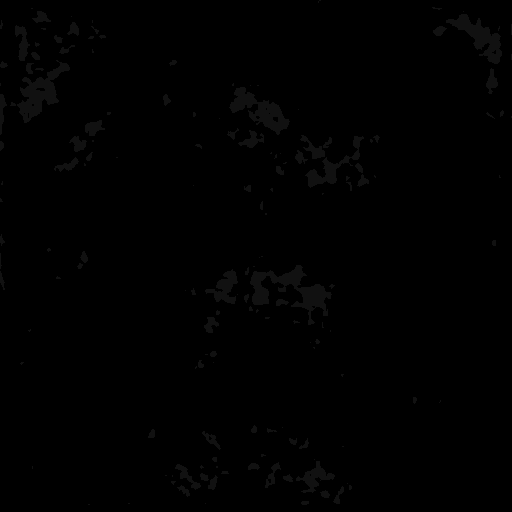

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

net = EHANet18(pretrained=True)
# print(net)
img = Image.open('data.jpg').convert("RGB")
img = img.resize((512, 512))
img_ = transform(img).unsqueeze(0)

result = net(img_)[0][-1]
result = F.interpolate(result, (512, 512), mode='bilinear', align_corners=True)

parsing = np.squeeze(result.data.max(1)[1].cpu().numpy(), axis=0)
print(parsing)
hello = (parsing==17)*parsing

rimg = Image.fromarray(hello.astype(np.uint8))
rimg
# fusing
# result = 1/(1+torch.exp(-result))
# result = torch.round(result,decimals=1)

In [ ]:
# from torchstat import stat

#     net = EHANet18(pretrained=False)
#     stat(net, (3, 256, 256))

tensor([[[[-0.1370, -0.2014, -0.2659,  ..., -1.5325, -1.6082, -1.6839],
          [-0.0670, -0.0895, -0.1120,  ..., -1.3489, -1.3773, -1.4057],
          [ 0.0031,  0.0225,  0.0420,  ..., -1.1653, -1.1464, -1.1274],
          ...,
          [-1.4004, -1.4209, -1.4414,  ..., -1.1274, -1.2347, -1.3420],
          [-1.5206, -1.5473, -1.5741,  ..., -1.1646, -1.2699, -1.3752],
          [-1.6407, -1.6738, -1.7069,  ..., -1.2018, -1.3051, -1.4083]],

         [[-1.6510, -1.5985, -1.5461,  ..., -0.8766, -0.7151, -0.5536],
          [-1.5877, -1.5327, -1.4777,  ..., -0.9884, -0.8515, -0.7147],
          [-1.5243, -1.4668, -1.4092,  ..., -1.1001, -0.9880, -0.8759],
          ...,
          [-1.1918, -1.1509, -1.1099,  ..., -1.1981, -1.2756, -1.3531],
          [-1.3777, -1.3186, -1.2595,  ..., -1.3006, -1.3740, -1.4473],
          [-1.5635, -1.4862, -1.4090,  ..., -1.4031, -1.4723, -1.5415]],

         [[ 1.7097,  1.7150,  1.7203,  ...,  0.4748,  0.3384,  0.2020],
          [ 1.6429,  1.6517,  

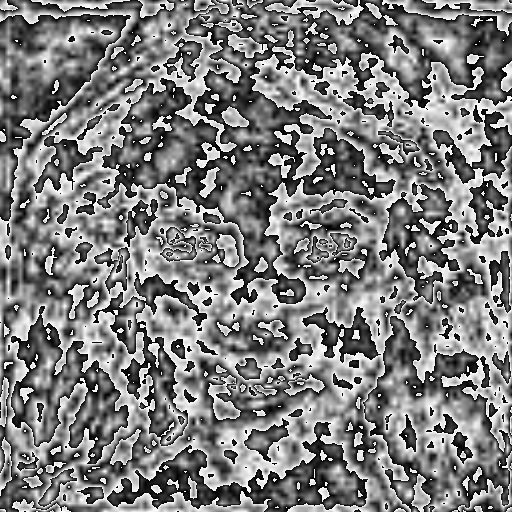

In [ ]:
print(result)

what = transforms.ToPILImage()
rimg = what(result[0][1])
rimg